In [584]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import scipy.stats as stats
from scipy import signal
from collections import namedtuple

In [585]:
N = 500
T = 1 # seconds
delta = T / N
a0 = 0.4
a1 = 0.015
a2 = 0.63

np.random.seed(42)
e1 = np.random.standard_normal(N + 1)
e2 = np.random.standard_normal(N + 1)

k = np.array(range(N + 1))
t = k * delta
y1 = a0 * np.sin(a1 * 2 * np.pi * t) + a2 * e1

y3 = np.exp(0.1 * t) + 2 * e2

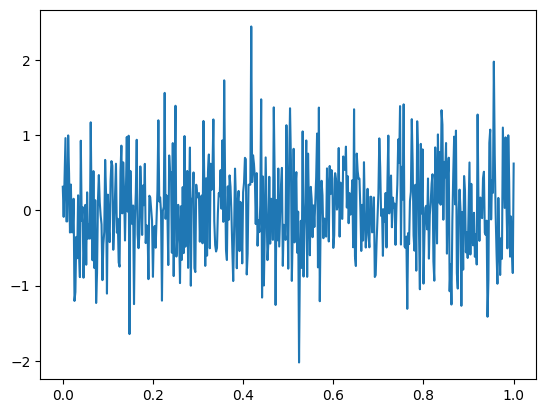

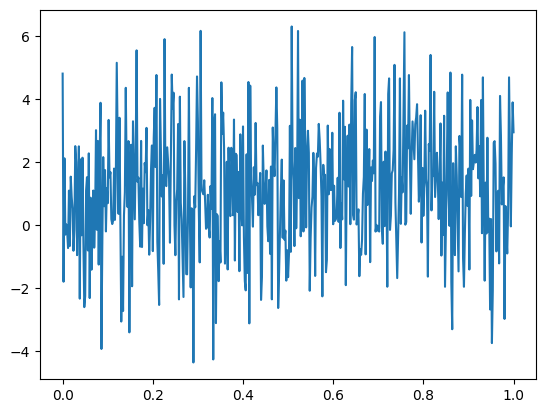

In [586]:
plt.plot(t, y1)
plt.show()
plt.plot(t, y3)
plt.show()

In [587]:
def confidence_ellipse(x, y, ax, p=0.99, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    pvalue : float
        Confidence probability of drawed ellipse

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Scaling factor according to given pvalue supposing (x, y) ~ N 
    n_std_for_quantile = stats.norm.ppf((1 + p) / 2)

    scale_x = np.sqrt(cov[0, 0]) * n_std_for_quantile
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std_for_quantile
    mean_y = np.mean(y)

    # A, such that xAx^T = 1 is our ellipse before scaling and rotation
    A = np.array([ [1/((ell_radius_x) ** 2), 0], [0, 1/((ell_radius_y) ** 2)]])
    scale = np.array([[1/(scale_x ** 2), 0], [0, 1/ (scale_y ** 2)]])
    
    angle = np.pi / 4
    rotation = np.array([ [np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)] ])
    
    A = rotation @ scale @ A @ rotation.T
    mu = np.array([mean_x, mean_y])

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse), A, mu

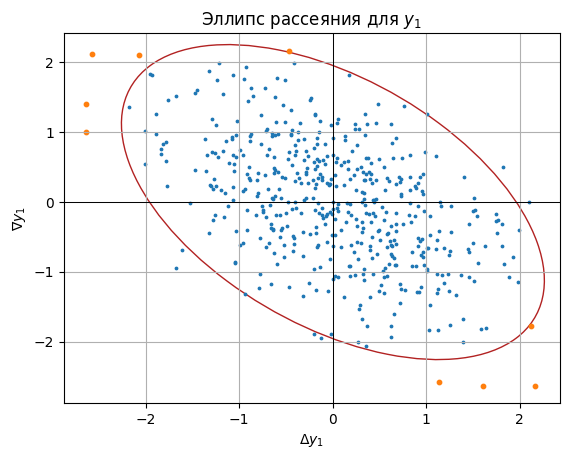

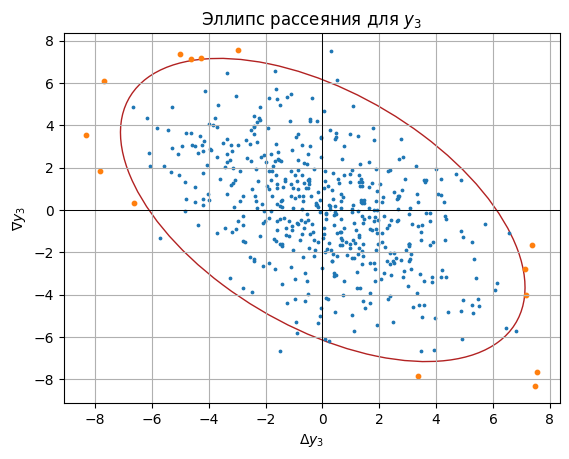

In [588]:
def replace_with_mean(arr: np.array, indices):
    result = np.copy(arr)
    for i in indices:
        if i == 0 or (i == result.shape[0] - 1):
            continue

        result[i] = 0.5 * (result [i - 1] + result[i + 1])
    return result

def ellipse(y, title: str):

    differences = y[1:] - y[:-1]
    forward_diff = differences[1:]
    backward_diff = differences[:-1]

    fig, ax = plt.subplots()

    _, A, mu = confidence_ellipse(forward_diff, backward_diff, ax, edgecolor='firebrick')

    ell_x = np.c_[forward_diff, backward_diff]
    diagonal_values = np.diag((ell_x - mu) @ A @ (ell_x - mu).T)  # вектор длины n
    signes = np.sign(forward_diff * backward_diff)
    anomalies = ell_x[(diagonal_values > 1) & (signes < 1)]
    anomalies_indices = np.where((diagonal_values > 1) & (signes < 1))[0]
    ell_x_clean = replace_with_mean(ell_x, anomalies_indices)
    
    ax.scatter(ell_x_clean[:, 0], ell_x_clean[:, 1], s=3)
    ax.scatter(anomalies[:,0], anomalies[:,1], s=10)

    ax.axhline(y=0, color='k', linewidth=0.7)
    ax.axvline(x=0, color='k', linewidth=0.7)
    plt.grid()
    plt.title(f'Эллипс рассеяния для {title}')
    plt.xlabel(f'$\\Delta${title}')
    plt.ylabel(f'$\\nabla${title}')
    plt.show()

ellipse(y1, '$y_1$')
ellipse(y3, '$y_3$')

По результату критерий серий "Тренд в y_1 отсутствует - True"


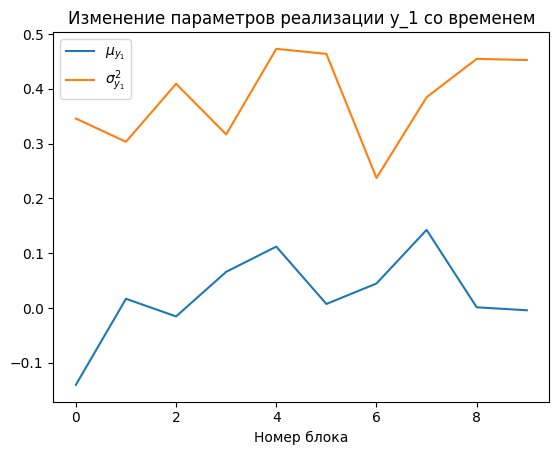

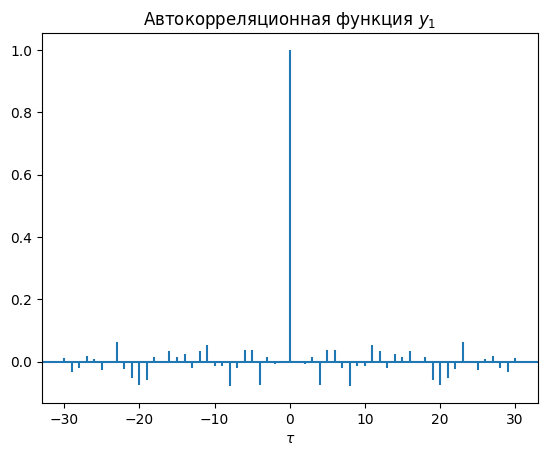

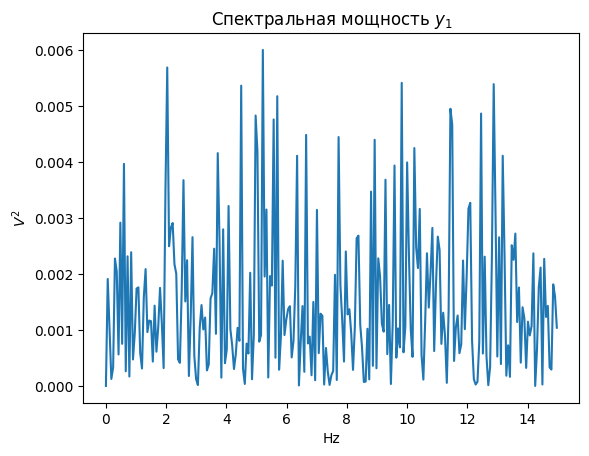

In [589]:
def estimate_m(arr: np.array) -> float:
    N = arr.shape[0]
    return (arr @ np.ones(N)) / N

def estimate_m_var(arr: np.array):
    N = arr.shape[0]
    m = estimate_m(arr)
    return m, ((arr - m).T @ (arr - m)) / (N - 1) 

def series_test(arr: np.array):
    N = arr.shape[0]
    arr = arr[1:] - arr[:-1]
    
    v, t_list = 1, []
    counter, elem_sign = 1, np.sign(arr[0])
    for x in np.nditer(arr[1:]):
        if elem_sign * x >= 0:
            counter += 1
        else:
            v += 1
            t_list.append(counter)
            counter, elem_sign = 1, np.sign(x)
    t_list.append(counter)
    t = np.max(t_list)
    if N <= 6:
        tmax = 5
    elif N <= 154 and N > 6:
        tmax = 6
    else:
        tmax = 7
    
    no_trend = (v > ((2 * (N - 1)) / 3 - 1.96 * np.sqrt((16 * N - 29) / 90))) and t < tmax
    return no_trend, v, t

def trend_test(y, title):
    mus = []
    vars = []
    for i in range(10):
        arr = y[50 * i: 50 * (i + 1)]
        mu, var = estimate_m_var(arr)
        mus.append(mu)
        vars.append(var)


    no_trend, _, _ = series_test(np.array(mus))    
    print(f'По результату критерий серий "Тренд в {title.replace("$", "")} отсутствует - {no_trend}"')
    plt.plot(mus, label="$\mu_{" + title + "}$")
    plt.plot(vars, label="$\sigma_{" + title + "}^2$")
    plt.legend()
    plt.title(f'Изменение параметров реализации {title} со временем')
    plt.xlabel('Номер блока')
    plt.show()

def corr_spectrum(y, title):
    plt.acorr(y, maxlags=30, normed=True)
    plt.title(f'Автокорреляционная функция {title}')
    plt.xlabel('$\\tau$')
    plt.show()

    f, Pxx = signal.periodogram(y.flatten(), scaling='spectrum', fs=30)
    plt.plot(f, Pxx)
    plt.xlabel('Hz')
    plt.ylabel('$V^2$')
    plt.title(f'Спектральная мощность {title}')
    plt.show()

trend_test(y1, 'y_1')
corr_spectrum(y1, '$y_1$')

По результату критерий серий "Тренд в y_3 отсутствует - True"


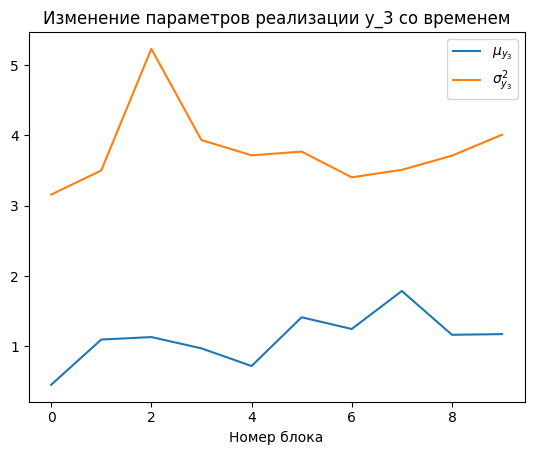

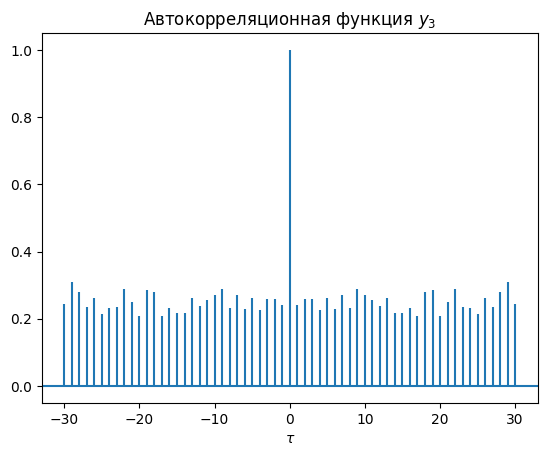

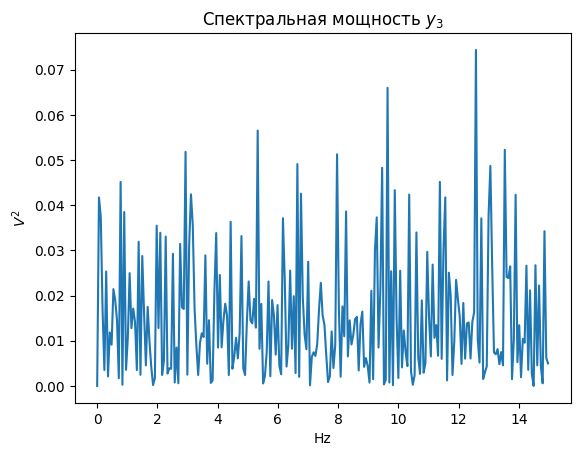

In [590]:
trend_test(y3, 'y_3')
corr_spectrum(y3, '$y_3$')

In [591]:
def print_characteristics(arr: np.array):
    mu, var = estimate_m_var(arr)
    skew = stats.skew(arr)
    kurtosis = stats.kurtosis(arr)
    kstest = stats.kstest(arr, 'norm', alternative='two-sided')

    print(f'Математическое ожидание - {mu:.3f}')
    print(f'Дисперсия - {var:.3f}')
    print(f'Асимметрия - {skew:.3f}')
    print(f'Эксцесс - {kurtosis:.3f}')
    print(f'Тест на нормальность Колмогорова-Смирнова - pvalue={kstest.pvalue:.1e}')
    
print('Характеристики y1')
print_characteristics(y1)

print('\nХарактеристики y3')
print_characteristics(y3)

Характеристики y1
Математическое ожидание - 0.024
Дисперсия - 0.383
Асимметрия - 0.179
Эксцесс - 0.254
Тест на нормальность Колмогорова-Смирнова - pvalue=9.5e-08

Характеристики y3
Математическое ожидание - 1.121
Дисперсия - 3.844
Асимметрия - 0.049
Эксцесс - -0.132
Тест на нормальность Колмогорова-Смирнова - pvalue=7.4e-64


$$  \hat{R}_{xy} (\tau) = \hat{R}_{xy} (k \Delta) = \frac{1}{N} \sum_{i=1}^{N-k} (x_i - m_x)(y_{i+k} - m_y) $$

In [592]:
def correlation_function(x: np.array, y: np.array, lags_count: int):
    if x.shape[0] != y.shape[0]:
        raise ValueError('x and y must be the same size')
    N = x.shape[0]

    if lags_count > N:
        raise ValueError('lags_count should be less than x, y size')
    
    mx = estimate_m(x)
    my = estimate_m(y)
    Rxy = []
    for k in range(lags_count):
        Rxy.append((x[:N-k] - mx).T @ (y[k:] - my) / N)

    return Rxy

def plot_corr_function(x: np.array, y: np.array, lags_count: int, title: str):
    is_autocorr = np.all(x == y)

    if is_autocorr:
        Rxy = correlation_function(x, x, lags_count)
    else:
        Rxy = correlation_function(x, y, lags_count)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].set_title('Сигналы')
    axs[0].plot(x[:100], label='x')
    if not is_autocorr:
        axs[0].plot(y[:100], label='y')
    axs[0].legend()

    axs[1].plot(Rxy)
    axs[1].set_title(f'{"Автокорреляционная" if is_autocorr else "Корреляционная"} функция {title}')
    axs[1].set_xlabel('$k\\Delta$')
    axs[1].hlines(0.05, 0, lags_count, color='k', linestyles='dashed')
    plt.show()

def signal_with_garmonics(N, delta = 1e-3):
    k = np.array(range(N))
    return 1 * np.ones(N) + 1.3 * np.sin(200 * 2 * np.pi * k * delta + 0.4) + 0.3 * np.sin(50 * 2 * np.pi * k * delta + 0.93)

def signal_linear_correlated(N, alpha=0.95):
    w = np.random.standard_normal(N)

    x = np.zeros(N)
    x[0] = w[0] / np.sqrt(1 - alpha**2)
    for n in range(1, N):
        x[n] = alpha * x[n-1] + np.sqrt(1 - alpha**2) * w[n]
    return x

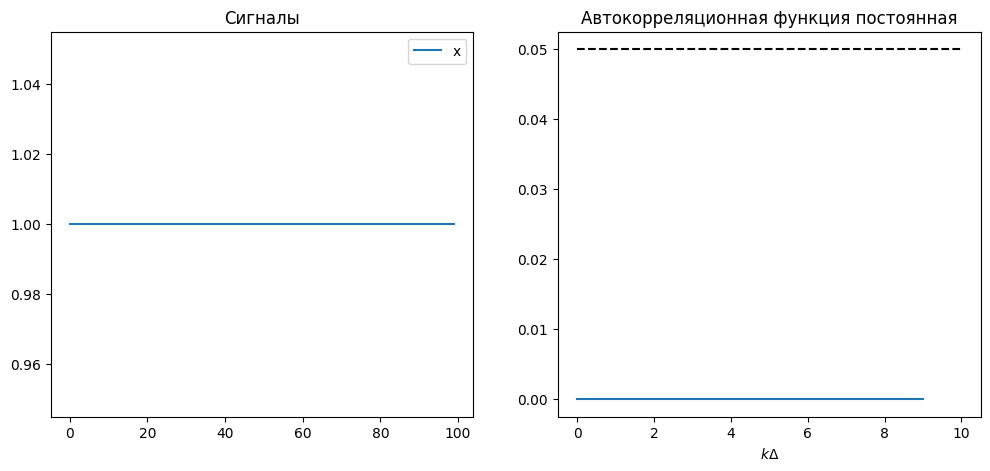

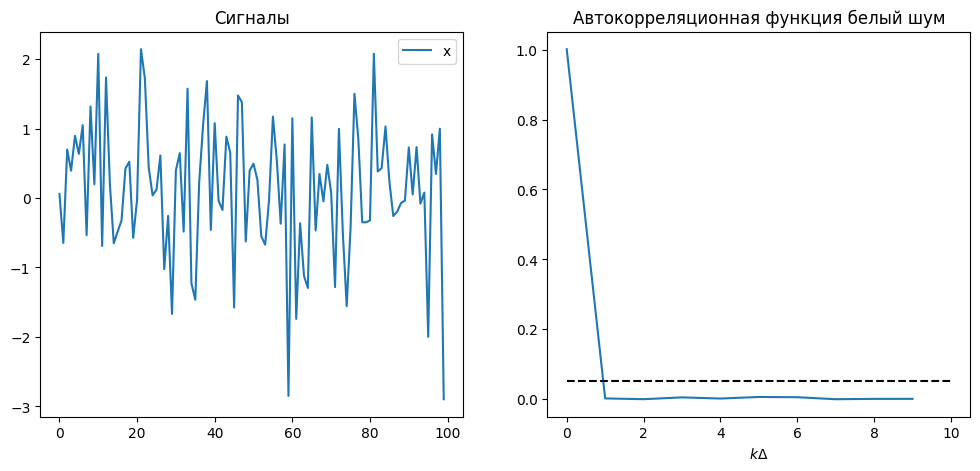

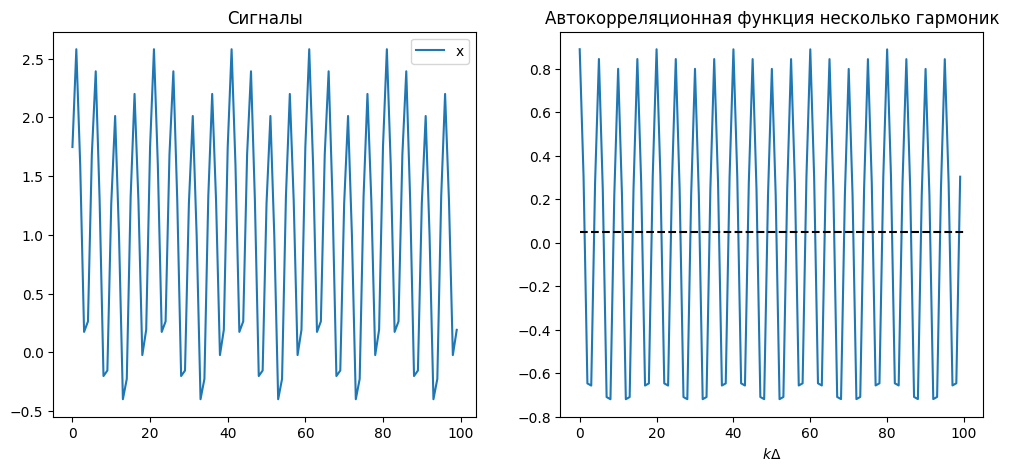

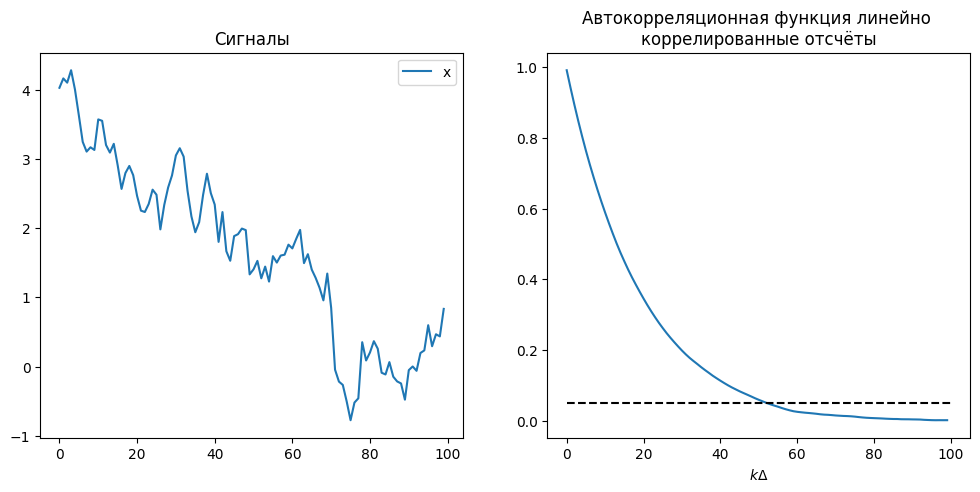

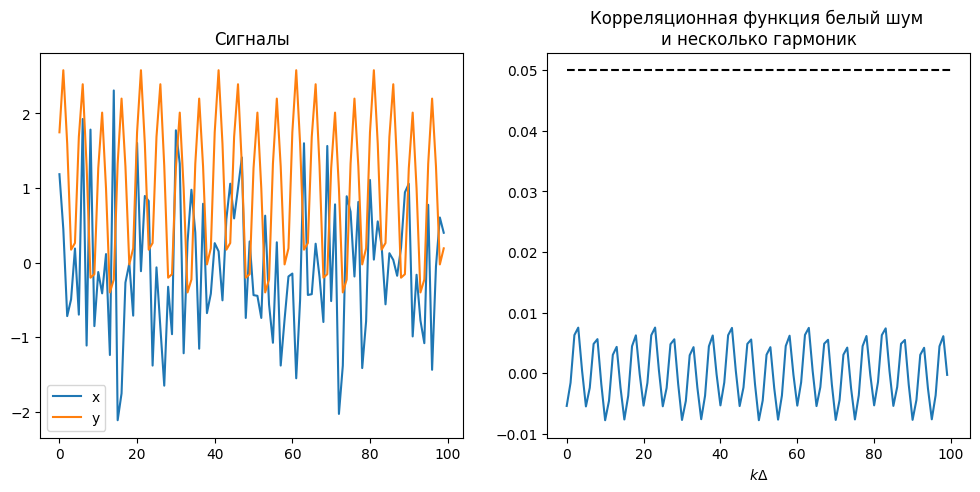

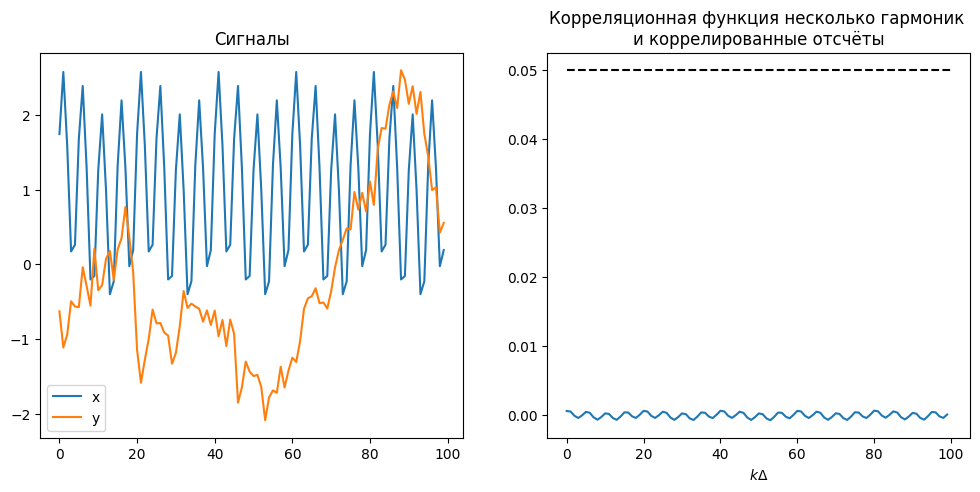

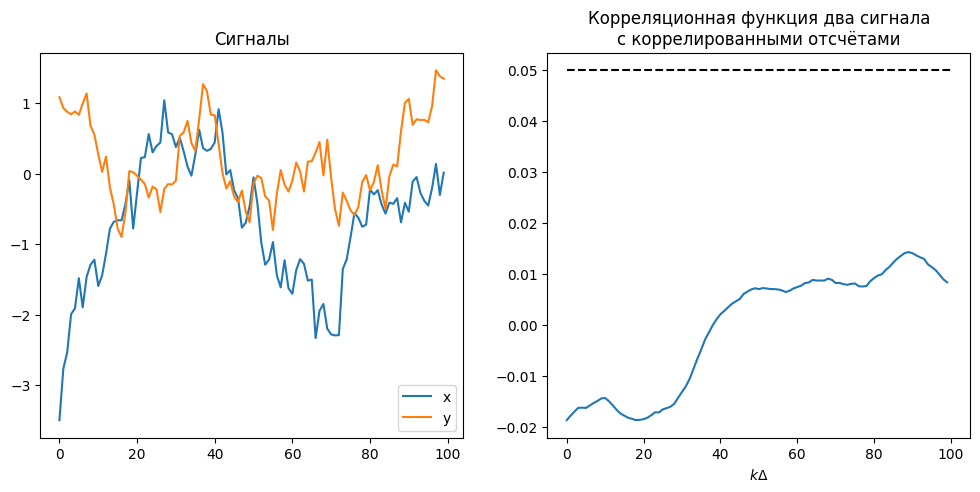

In [593]:
Realization = namedtuple('Realization', 'generate_x generate_y lags_to_plot')
realizations = {
    'постоянная': Realization(np.ones, None, 10),
    'белый шум': Realization(np.random.standard_normal, None, 10),
    'несколько гармоник': Realization(signal_with_garmonics, None, 100),
    'линейно \nкоррелированные отсчёты': Realization(signal_linear_correlated, None, 100),
    'белый шум \nи несколько гармоник': Realization(np.random.standard_normal, signal_with_garmonics, 100),
    'несколько гармоник \nи коррелированные отсчёты': Realization(signal_with_garmonics, signal_linear_correlated, 100),
    'два сигнала\nс коррелированными отсчётами': Realization(signal_linear_correlated, signal_linear_correlated, 100)
}

N = 100_000

for title, realization in realizations.items():
    x = realization.generate_x(N)
    if realization.generate_y is None:
        plot_corr_function(x, x, realization.lags_to_plot, title)
    else:
        y = realization.generate_y(N)
        plot_corr_function(x, y, realization.lags_to_plot, title)

In [594]:
def periodogram(x: np.array, delta):
    N = x.shape[0]
    I = []

    i = np.array(range(N))
    for k in range(int(N / 2)):
        alpha = x.T @ np.cos( (2 * np.pi * k * i) / N )
        beta = x.T @ np.sin( (2 * np.pi * k * i) / N )
        I.append(delta / N * (alpha ** 2 + beta ** 2))
    
    return I

# spectral density
def esimate_spe(x: np.array, delta, window):
    N = x.shape[0]
    Sxx = []
    I = np.array(periodogram(x, delta))

    j = np.arange(-N / 4 + 1, N / 4, 1)
    for k in range(int(N / 4)):
        indices = np.abs( np.astype((k - j), np.int16) )
        Sxx.append( I[indices].T @ window(j) )
    
    return Sxx

def rect_window(j, M = 100):
    w = np.where(np.abs(j) <= M, 1/(2*M + 1), 0)
    return w

def bartlett_window(j, M = 100):
    w = np.where(np.abs(j) <= M, (1 - np.abs(j) / M) / M, 0)
    return w

def hamming_window(j, M = 100):
    w = np.where(np.abs(j) <= M, ( 0.54 + 0.46 * np.cos(np.pi * j / M) ) / (1.08 * M + 0.08), 0)
    return w

def han_window(j, M = 100):
    w = np.where(np.abs(j) <= M, (1 + np.cos(np.pi * j / M)) / (2 * M), 0)
    return w

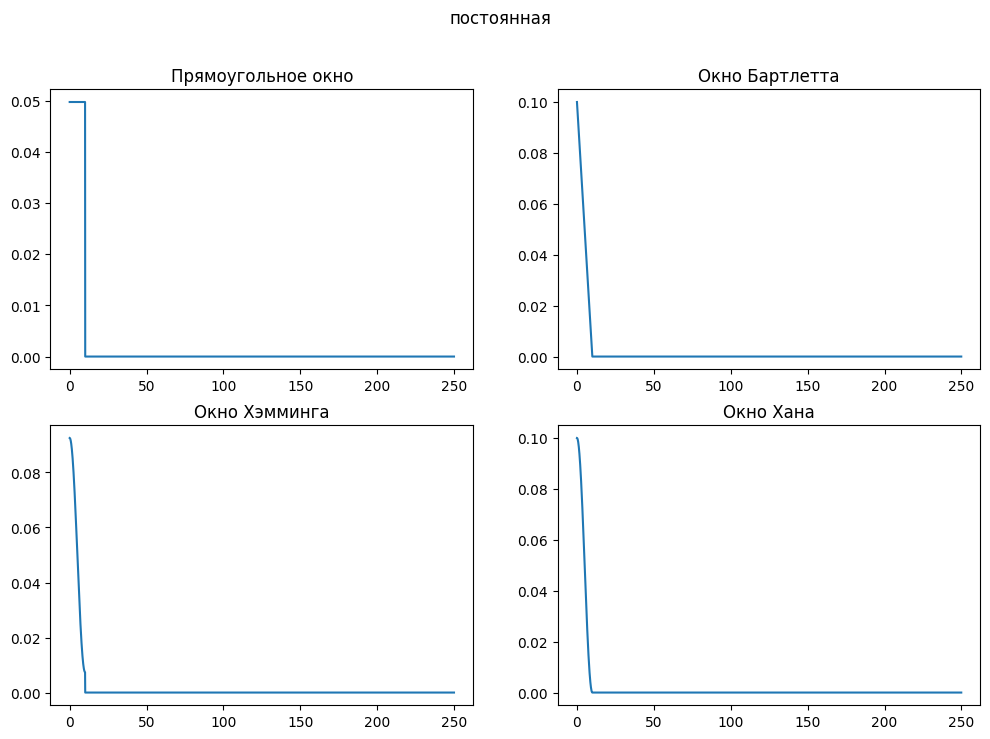

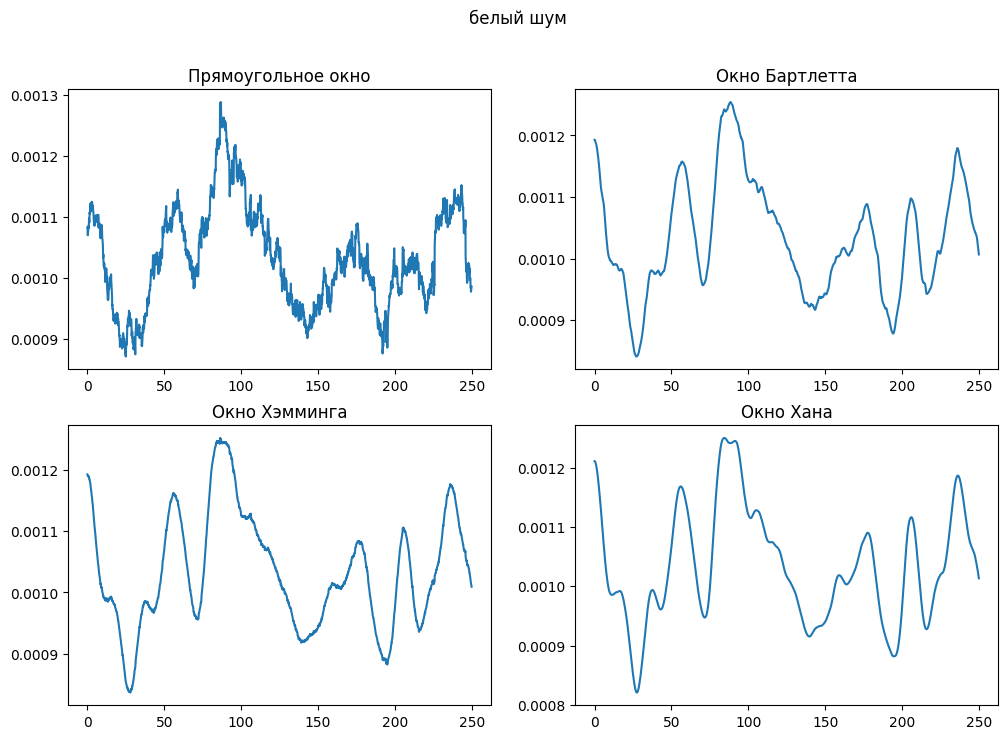

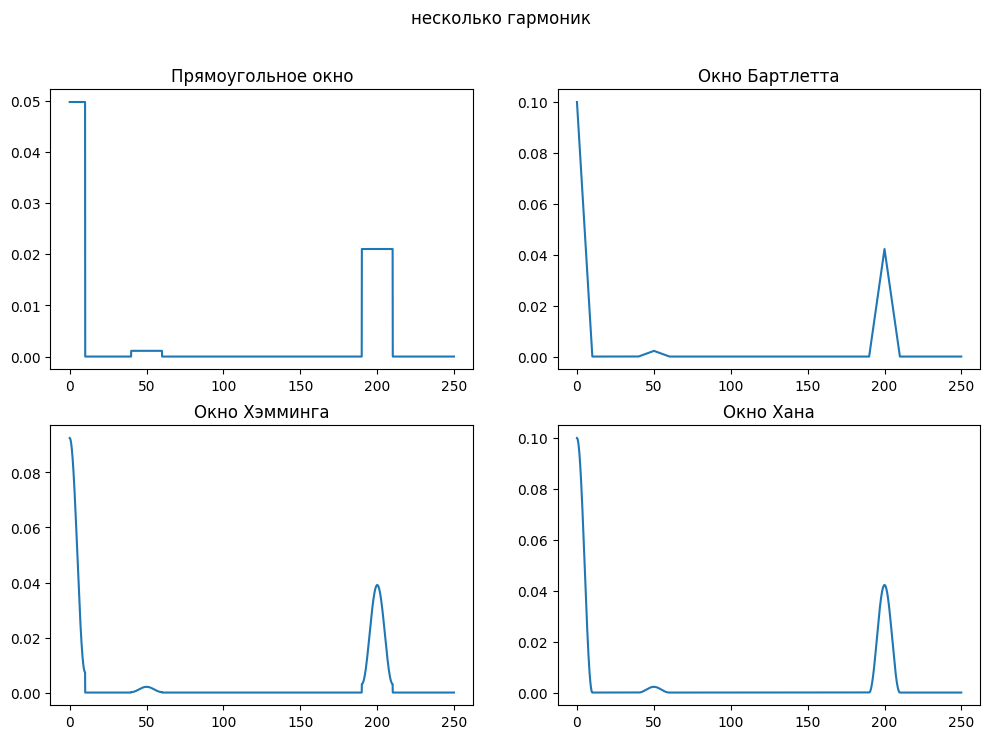

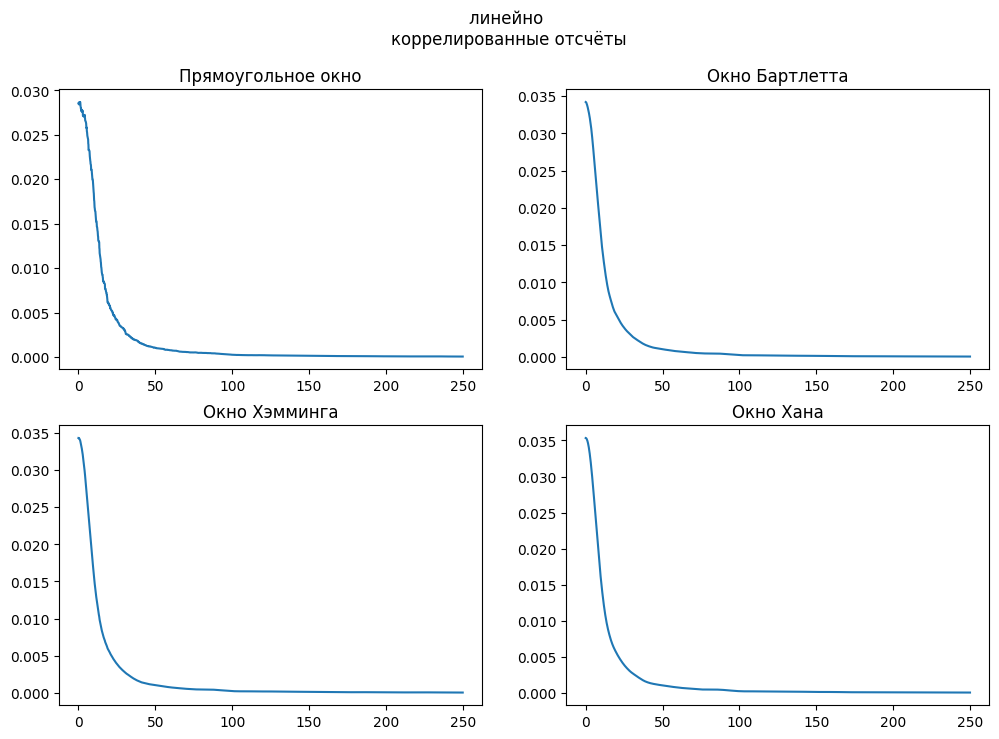

In [595]:
realizations = {
    'постоянная': Realization(np.ones, None, 10),
    'белый шум': Realization(np.random.standard_normal, None, 10),
    'несколько гармоник': Realization(signal_with_garmonics, None, 100),
    'линейно \nкоррелированные отсчёты': Realization(signal_linear_correlated, None, 100),
}

windows = {
    'Прямоугольное окно': rect_window,
    'Окно Бартлетта': bartlett_window,
    'Окно Хэмминга': hamming_window,
    'Окно Хана': han_window,
}

N = 10000
delta = 1e-3
for title, realization in realizations.items():
    x = realization.generate_x(N)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    for i, window_name in enumerate(windows):
        Sxx = esimate_spe(x, delta, windows[window_name])
        f = np.arange(len(Sxx)) / (delta * N)

        plot_index = int(i / 2), i % 2
        axs[plot_index].set_title(window_name)
        axs[plot_index].plot(f, Sxx)

    plt.suptitle(title)
    plt.show()